In [1]:
import traffic
import pandas as pd 
import os
from traffic.core import Traffic
from biblio_herramienta.herramienta import *
from biblio_herramienta.tratardatos import *
from biblio_herramienta.ml import *

In [2]:
archivoBBDD = r"/Users/jaimebowen/OneDrive/TFGSeptiembre/libros_a_scripts/datos_sectores/BBDD_bilbao.csv"

In [3]:
archivoPRUEBA = r"/Users/jaimebowen/OneDrive/TFGSeptiembre/libros/datos_sectores/datos_f_c_pares_bilbao_magnitudes.csv"

In [4]:
bbdd = pd.read_csv(archivoBBDD)

In [5]:
bbdd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463080 entries, 0 to 463079
Data columns (total 39 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          463080 non-null  int64  
 1   Unnamed: 0.1        463080 non-null  int64  
 2   ave1                463080 non-null  object 
 3   ave2                463080 non-null  object 
 4   Unnamed: 0_1        463080 non-null  int64  
 5   Unnamed: 0.1_1      463080 non-null  int64  
 6   Unnamed: 0.1.1_1    463080 non-null  int64  
 7   altitude_1          463080 non-null  float64
 8   geoaltitude_1       463080 non-null  float64
 9   groundspeed_1       463080 non-null  float64
 10  latitude_1          463080 non-null  float64
 11  longitude_1         463080 non-null  float64
 12  timestamp_1         463080 non-null  object 
 13  track_1             463080 non-null  float64
 14  vertical_rate_1     463080 non-null  float64
 15  track_unwrapped_1   463080 non-nul

In [6]:
cols = [0,1,2,3,4,5,6,8,12,13,16,17,18,21,25,26,19,29,37,38]
bbdd.drop(bbdd.columns[cols],axis=1,inplace= True)
bbdd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463080 entries, 0 to 463079
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   altitude_1          463080 non-null  float64
 1   groundspeed_1       463080 non-null  float64
 2   latitude_1          463080 non-null  float64
 3   longitude_1         463080 non-null  float64
 4   vertical_rate_1     463080 non-null  float64
 5   track_unwrapped_1   463080 non-null  float64
 6   altitude_2          463080 non-null  float64
 7   groundspeed_2       463080 non-null  float64
 8   latitude_2          463080 non-null  float64
 9   longitude_2         463080 non-null  float64
 10  vertical_rate_2     463080 non-null  float64
 11  track_unwrapped_2   463080 non-null  float64
 12  Init separation     463080 non-null  float64
 13  Init acimut         463080 non-null  float64
 14  Var GS Module       463080 non-null  float64
 15  Var Track           463080 non-nul

In [24]:
bbdd.MinDis.value_counts()

10.000000    462963
0.030329          2
1.054209          1
0.031199          1
0.071402          1
              ...  
2.790849          1
3.448982          1
0.036788          1
3.546056          1
0.094328          1
Name: MinDis, Length: 117, dtype: int64

# 2. Generación de los datatsets
Con los datos cargados, ahora se van a generar dos BBDD:
* La que se va a usar para entrenar al modelo
* La que se va a usar para saber si el modelo ha sido bien entrenado

In [7]:
X = bbdd.drop(columns = ["Conflicto"],axis =1)
y = bbdd["Conflicto"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X , y , stratify = y, test_size = 0.2, random_state = 42)

# 3. Generación de Pipelines 
Como se comenta en el apartado 2 el TFG, se va a usar varios método para realizar las predicciones de los datos obtenidos y probar cual es aquel que tiene mayor precisión.  


## 3.1 Modelos lineales
### 3.1.1 Clasificadro Ridge

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
# Clasificador Ridge
ridge_pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('ridge_classifier',RidgeClassifier(alpha = 0.1))


])

# Clasificador 

In [9]:
ridge_pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge_classifier', RidgeClassifier(alpha=0.1))])

In [34]:
y_train.value_counts()

0    370370
1        94
Name: Conflicto, dtype: int64

In [10]:
accuracy_score(y_test,ridge_pipe.predict(X_test))

0.9997516627796493

### 3.1.1 Clasificadro SVM

In [36]:
from sklearn.svm import LinearSVC
svm_pipe = Pipeline((
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(C=1, loss = 'hinge'))
))

In [37]:
svm_pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge'))])

In [38]:
accuracy_score(svm_pipe.predict(X_test),y_test)

0.9997516627796493

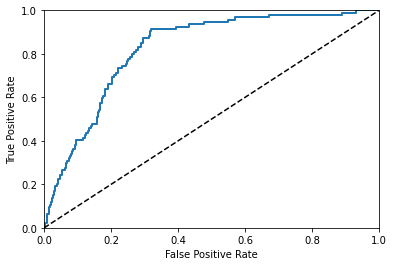

In [39]:
curvaROC(ridge_pipe,X_train,y_train)

In [40]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(ridge_pipe, X_train, y_train, cv=3)

In [41]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[370370,      0],
       [    94,      0]])

In [47]:
prue = pd.read_csv(archivoPRUEBA)

In [43]:
prue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463080 entries, 0 to 463079
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          463080 non-null  int64  
 1   ave1                463080 non-null  object 
 2   ave2                463080 non-null  object 
 3   altitude_1          463080 non-null  float64
 4   geoaltitude_1       463080 non-null  float64
 5   groundspeed_1       463080 non-null  float64
 6   latitude_1          463080 non-null  float64
 7   longitude_1         463080 non-null  float64
 8   timestamp_1         463080 non-null  object 
 9   track_1             463080 non-null  float64
 10  vertical_rate_1     463080 non-null  float64
 11  track_unwrapped_1   463080 non-null  float64
 12  cluster_1           463080 non-null  int64  
 13  altitude_2          463080 non-null  float64
 14  geoaltitude_2       463080 non-null  float64
 15  groundspeed_2       463080 non-nul

In [49]:
cols = [0,1,2,4,5,8,12,13,14,18,22]
y_prue_svm = ridge_pipe.predict(prue.drop(prue.columns[cols],axis=1))
prue["Conflicto_svm"] = y_prue_svm



ValueError: X has 19 features, but this StandardScaler is expecting 18 features as input.

In [50]:
prue.head()

,Unnamed: 0,ave1,ave2,altitude_1,geoaltitude_1,groundspeed_1,latitude_1,longitude_1,timestamp_1,track_1,...,vertical_rate_2,track_unwrapped_2,cluster_2,Init separation,Init acimut,Var GS Module,Var Track,Var init altitude,Var Vertical speed,Conflicto_svm
0,0,IBE31AA_123,AFR149H_346,35025.0,35000.0,487.0,44.375129,-3.974840,2019-01-31 00:00:00+00:00,187.314737,...,-64.0,187.314737,3,0.0,180.0,0.0,0.0,0.0,0.0,0
1,1,IBE31AA_123,IBE31CW_128,35025.0,35000.0,487.0,44.371731,-3.975376,2019-01-31 00:00:01+00:00,187.081212,...,-64.0,187.081212,3,0.0,180.0,0.0,0.0,0.0,0.0,0
2,2,IBE31AA_123,RAM804_004,35025.0,35000.0,488.0,44.370300,-3.975612,2019-01-31 00:00:02+00:00,186.950112,...,-64.0,186.950112,3,0.0,180.0,0.0,0.0,0.0,0.0,0
3,3,IBE31AA_123,RAM803_010,35025.0,35000.0,487.0,44.368423,-3.975939,2019-01-31 00:00:03+00:00,186.716705,...,-64.0,186.716705,3,0.0,180.0,0.0,0.0,0.0,0.0,0
4,4,IBE31AA_123,IBE31YL_129,35025.0,35000.0,488.0,44.364670,-3.976528,2019-01-31 00:00:04+00:00,186.236442,...,-64.0,186.236442,3,0.0,180.0,0.0,0.0,0.0,0.0,0


In [44]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370464 entries, 413190 to 257330
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   altitude_1          370464 non-null  float64
 1   groundspeed_1       370464 non-null  float64
 2   latitude_1          370464 non-null  float64
 3   longitude_1         370464 non-null  float64
 4   vertical_rate_1     370464 non-null  float64
 5   track_unwrapped_1   370464 non-null  float64
 6   altitude_2          370464 non-null  float64
 7   groundspeed_2       370464 non-null  float64
 8   latitude_2          370464 non-null  float64
 9   longitude_2         370464 non-null  float64
 10  vertical_rate_2     370464 non-null  float64
 11  track_unwrapped_2   370464 non-null  float64
 12  Init separation     370464 non-null  float64
 13  Init acimut         370464 non-null  float64
 14  Var GS Module       370464 non-null  float64
 15  Var Track           370464 no